In [1]:
# #!/bin/bash
# !kaggle datasets download robikscube/hourly-energy-consumption

In [2]:
# !unzip hourly-energy-consumption.zip

In [3]:
# --- Basic Data Handling and Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import zipfile
import io

# --- Time Series Analysis ---
from statsmodels.tsa.seasonal import seasonal_decompose

# --- Scikit-learn for Machine Learning ---
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- TensorFlow and Keras for Deep Learning ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Set plotting style and random seed for reproducibility ---
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# --- Define the local file to load ---
file_name = 'DAYTON_hourly.csv'

df = pd.read_csv(file_name,
                 parse_dates=['Datetime'],
                 index_col='Datetime')
print(f"Dataset '{file_name}' loaded successfully.")

print("\nFirst 5 rows of the dataset:")
print(df.head())

print(f"\nDataset Shape: {df.shape}")
print(f"Time range: {df.index.min()} to {df.index.max()}")

Dataset 'DAYTON_hourly.csv' loaded successfully.

First 5 rows of the dataset:
                     DAYTON_MW
Datetime                      
2004-12-31 01:00:00     1596.0
2004-12-31 02:00:00     1517.0
2004-12-31 03:00:00     1486.0
2004-12-31 04:00:00     1469.0
2004-12-31 05:00:00     1472.0

Dataset Shape: (121275, 1)
Time range: 2004-10-01 01:00:00 to 2018-08-03 00:00:00


Missing values per column:
DAYTON_MW    0
dtype: int64


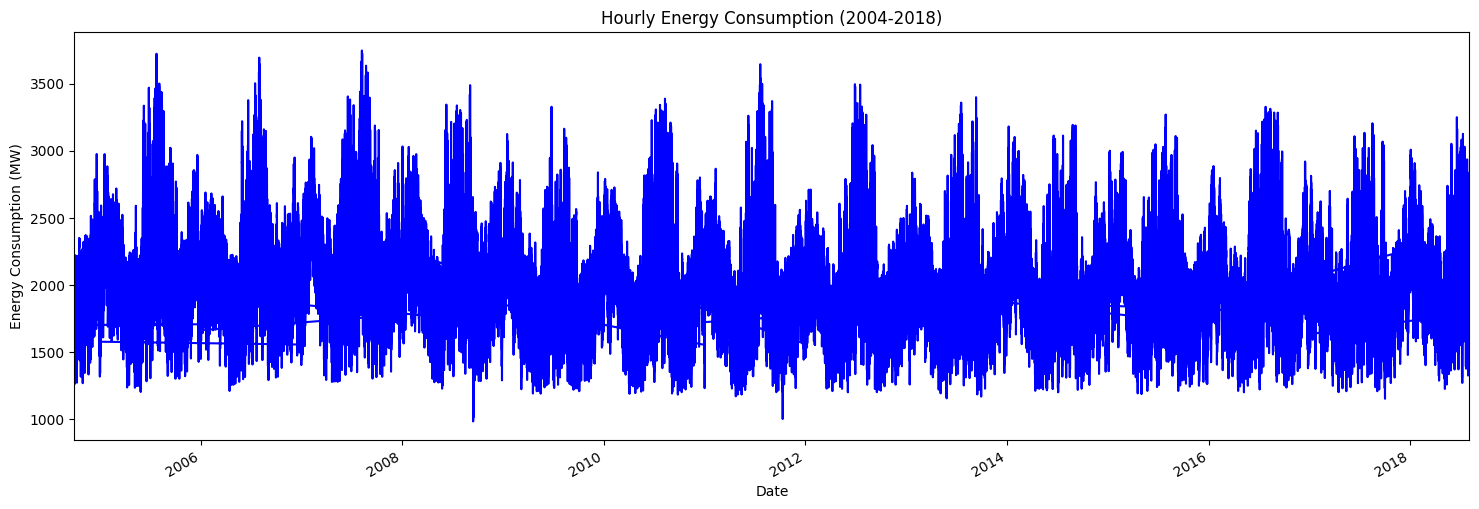

In [5]:
# --- Check for Missing Values ---
print("Missing values per column:")
print(df.isnull().sum())

# Rename the column for easier access
df = df.rename(columns={'DAYTON_MW': 'energy_mw'})

# --- Plot the entire time series ---
fig, ax = plt.subplots(figsize=(18, 6))
df['energy_mw'].plot(ax=ax, title='Hourly Energy Consumption (2004-2018)', color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (MW)')
ax.autoscale(axis='x', tight=True)
plt.show()

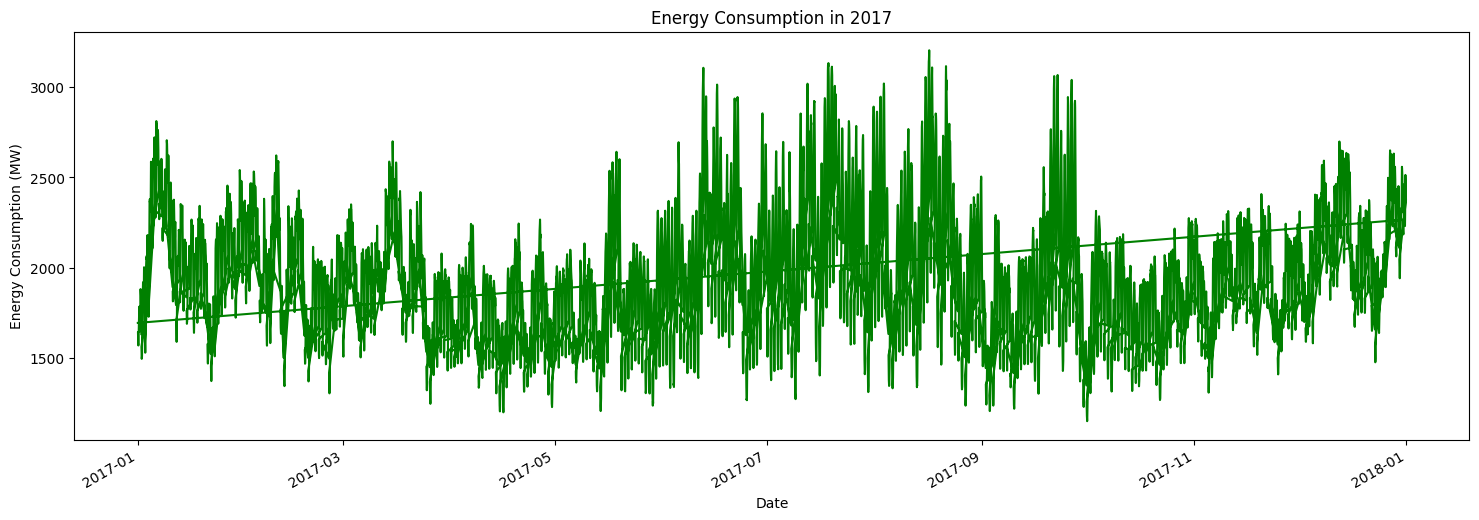

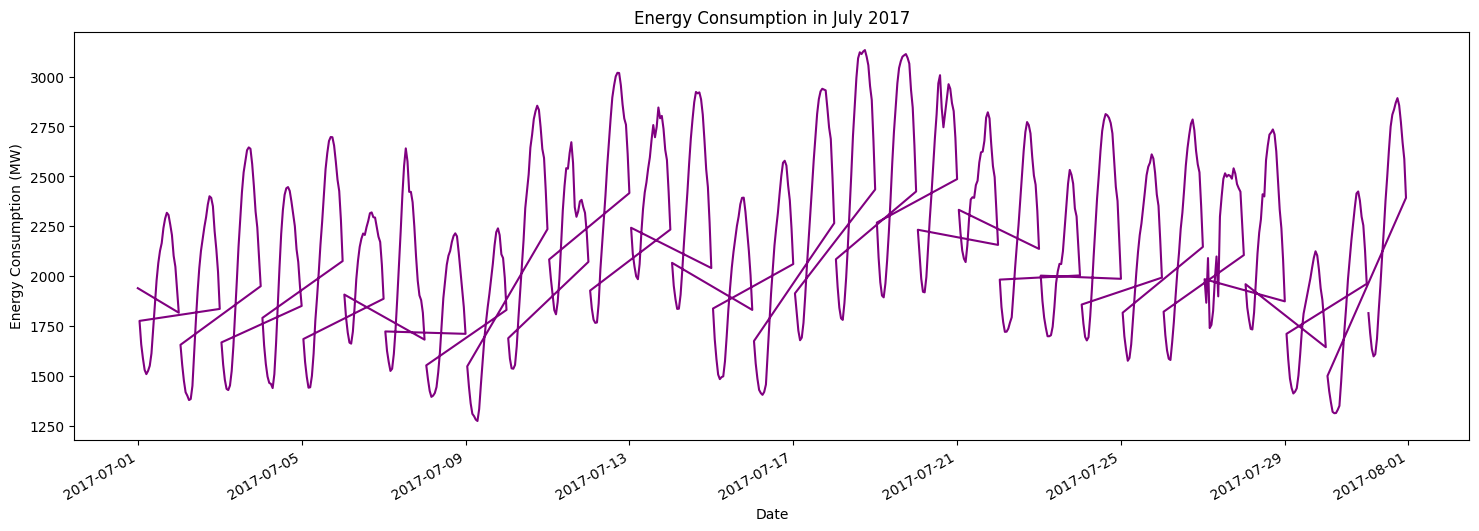

In [6]:
# --- Zooming in on specific time periods ---

# Plot one year of data
fig, ax = plt.subplots(figsize=(18, 6))
df['energy_mw']['2017'].plot(ax=ax, title='Energy Consumption in 2017', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (MW)')
plt.show()

# Plot one month of data
fig, ax = plt.subplots(figsize=(18, 6))
df['energy_mw']['2017-07'].plot(ax=ax, title='Energy Consumption in July 2017', color='purple')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (MW)')
plt.show()

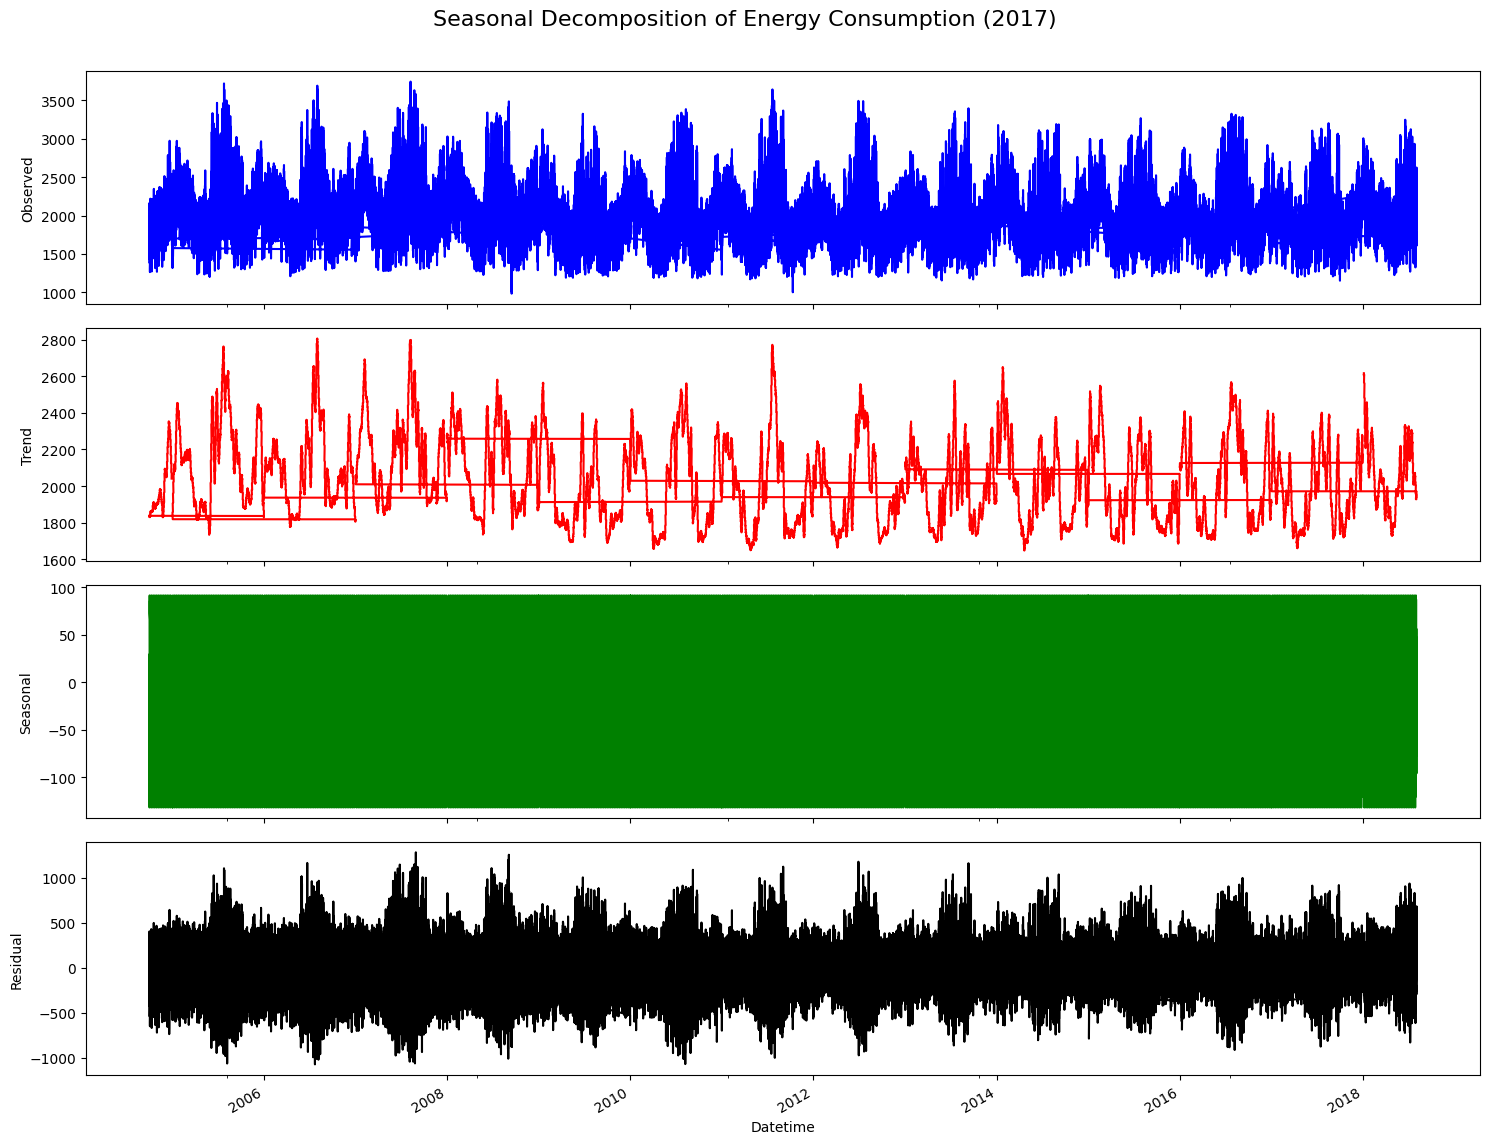

In [7]:
# --- Seasonal Decomposition ---
# We use a smaller sample for decomposition to make patterns visible
sample_data = df['energy_mw']

# Decompose the time series (using an additive model)
# The period is 24*7 for weekly seasonality on hourly data
result = seasonal_decompose(sample_data, model='additive', period=24*7)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=ax1, legend=False, color='b')
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, legend=False, color='r')
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, legend=False, color='g')
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, legend=False, color='k')
ax4.set_ylabel('Residual')
plt.suptitle('Seasonal Decomposition of Energy Consumption (2017)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

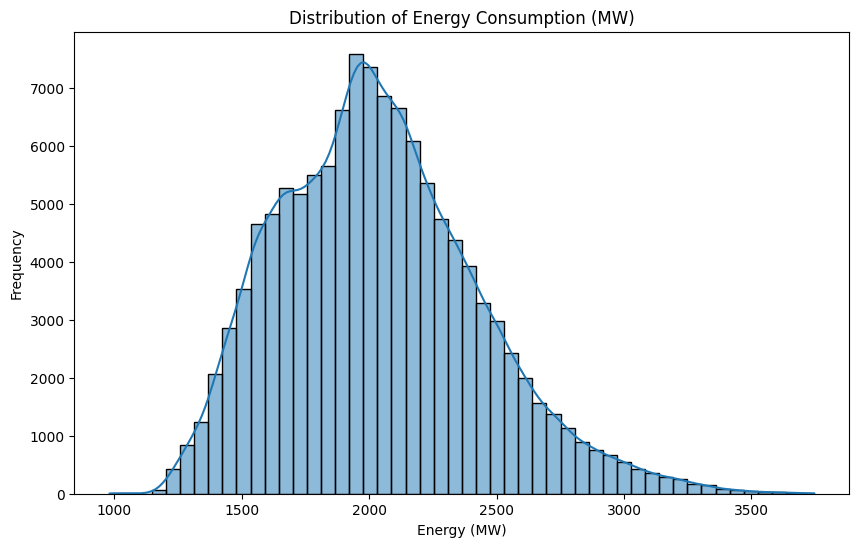

/tmp/ipython-input-1459871408.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
/tmp/ipython-input-1459871408.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


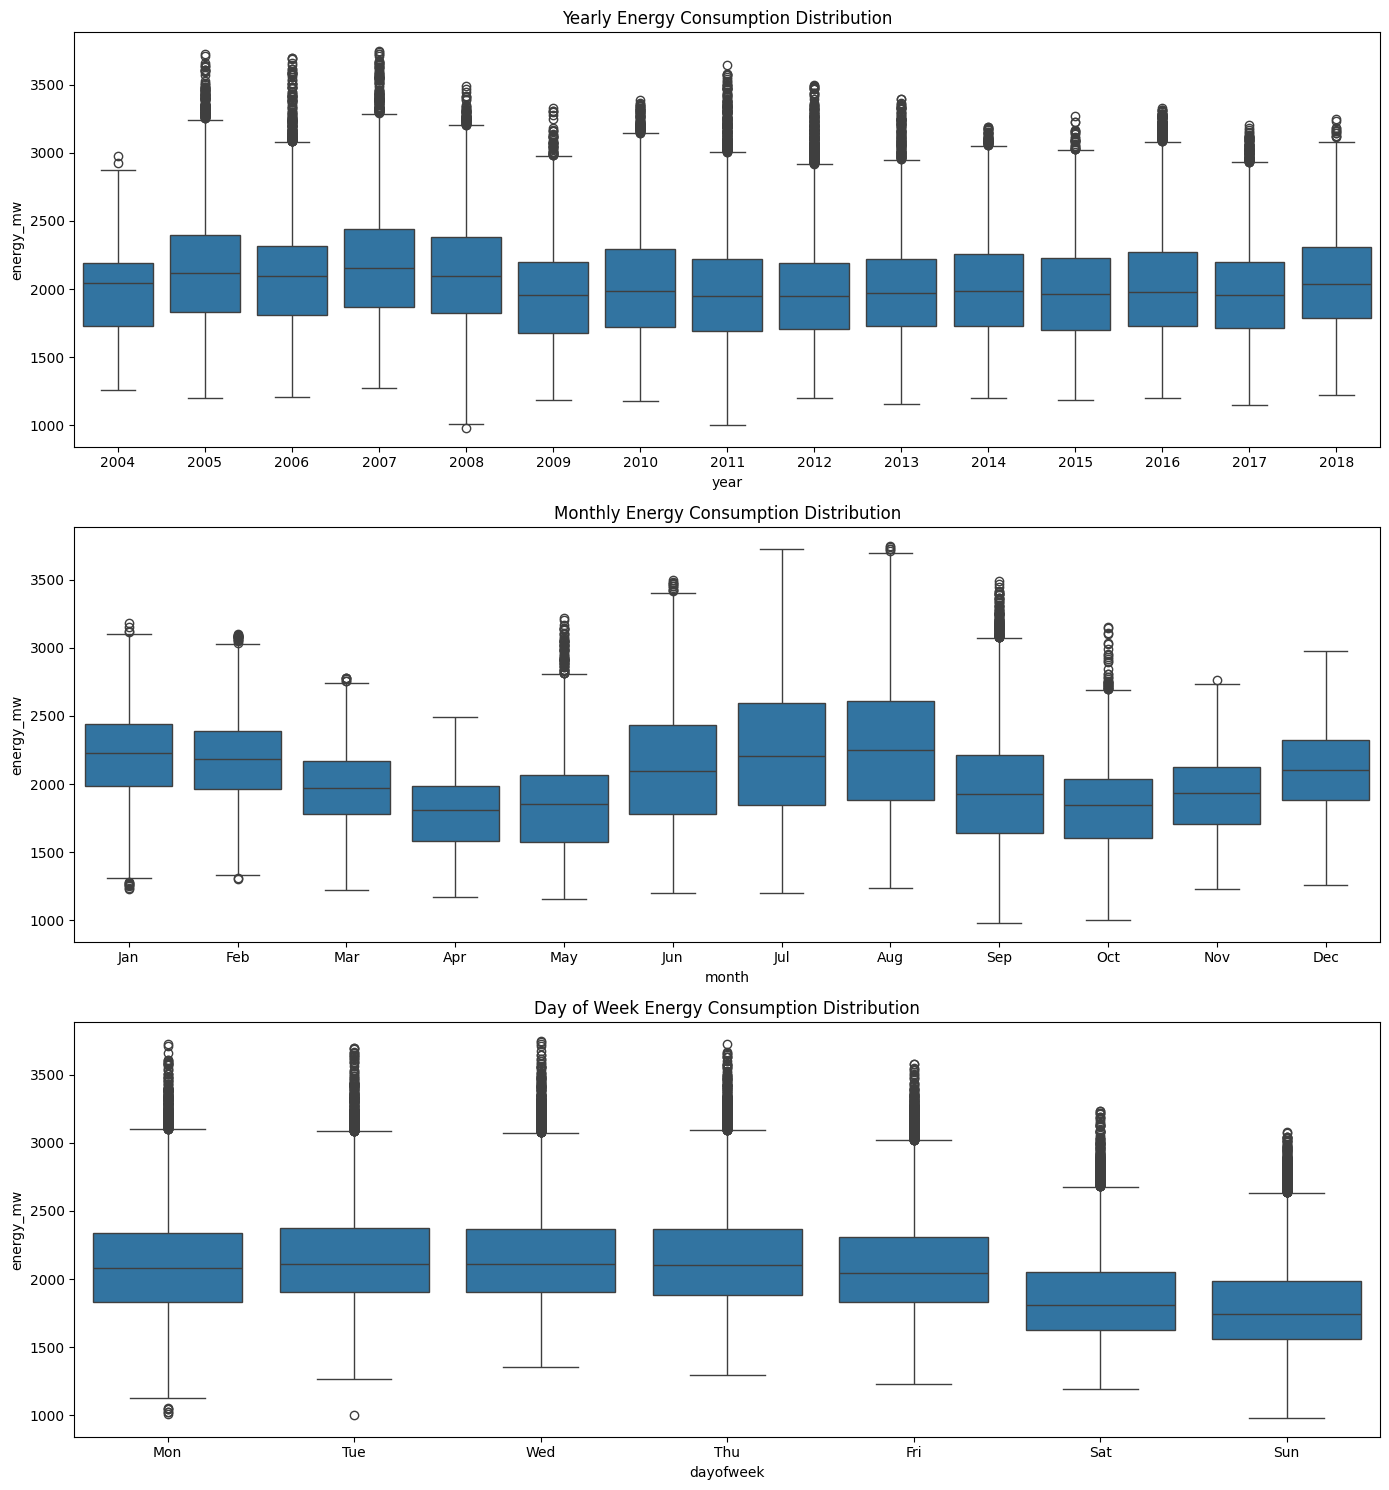

In [8]:
# --- Distribution Plot ---
plt.figure(figsize=(10, 6))
sns.histplot(df['energy_mw'], kde=True, bins=50)
plt.title('Distribution of Energy Consumption (MW)')
plt.xlabel('Energy (MW)')
plt.ylabel('Frequency')
plt.show()

# --- Boxplots for Seasonality Analysis ---
df_copy = df.copy()
df_copy['year'] = df_copy.index.year
df_copy['month'] = df_copy.index.month
df_copy['dayofweek'] = df_copy.index.dayofweek

fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# Yearly Boxplot
sns.boxplot(x='year', y='energy_mw', data=df_copy, ax=axes[0])
axes[0].set_title('Yearly Energy Consumption Distribution')

# Monthly Boxplot
sns.boxplot(x='month', y='energy_mw', data=df_copy, ax=axes[1])
axes[1].set_title('Monthly Energy Consumption Distribution')
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


# Day of Week Boxplot
sns.boxplot(x='dayofweek', y='energy_mw', data=df_copy, ax=axes[2])
axes[2].set_title('Day of Week Energy Consumption Distribution')
axes[2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout()
plt.show()

In [9]:
# --- 1. Create Time-Based Features ---
def create_time_features(df):
    """
    Creates time series features from a datetime index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek  # Monday=0, Sunday=6
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    return df

df_features = create_time_features(df)

# --- 2. Create Lag Features ---
def create_lag_features(df, lags):
    """
    Creates lag features for the target variable.
    """
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df['energy_mw'].shift(lag)
    return df

# Using lags that represent patterns from the last day and last week
lags_to_create = [1, 2, 3, 24, 48, 168] # 1-3 hours ago, 1 day, 2 days, 1 week
df_features = create_lag_features(df_features, lags_to_create)

# Drop rows with NaN values created by lag features
df_features.dropna(inplace=True)

print("Features created. New dataset shape:", df_features.shape)
print(df_features.head())

Features created. New dataset shape: (121107, 14)
                     energy_mw  hour  dayofweek  quarter  month  year  \
Datetime                                                                
2004-12-24 01:00:00     2035.0     1          4        4     12  2004   
2004-12-24 02:00:00     1968.0     2          4        4     12  2004   
2004-12-24 03:00:00     1950.0     3          4        4     12  2004   
2004-12-24 04:00:00     1954.0     4          4        4     12  2004   
2004-12-24 05:00:00     1968.0     5          4        4     12  2004   

                     dayofyear  weekofyear   lag_1   lag_2   lag_3  lag_24  \
Datetime                                                                     
2004-12-24 01:00:00        359          52  1960.0  2069.0  2138.0  2218.0   
2004-12-24 02:00:00        359          52  2035.0  1960.0  2069.0  2154.0   
2004-12-24 03:00:00        359          52  1968.0  2035.0  1960.0  2116.0   
2004-12-24 04:00:00        359          52  1950

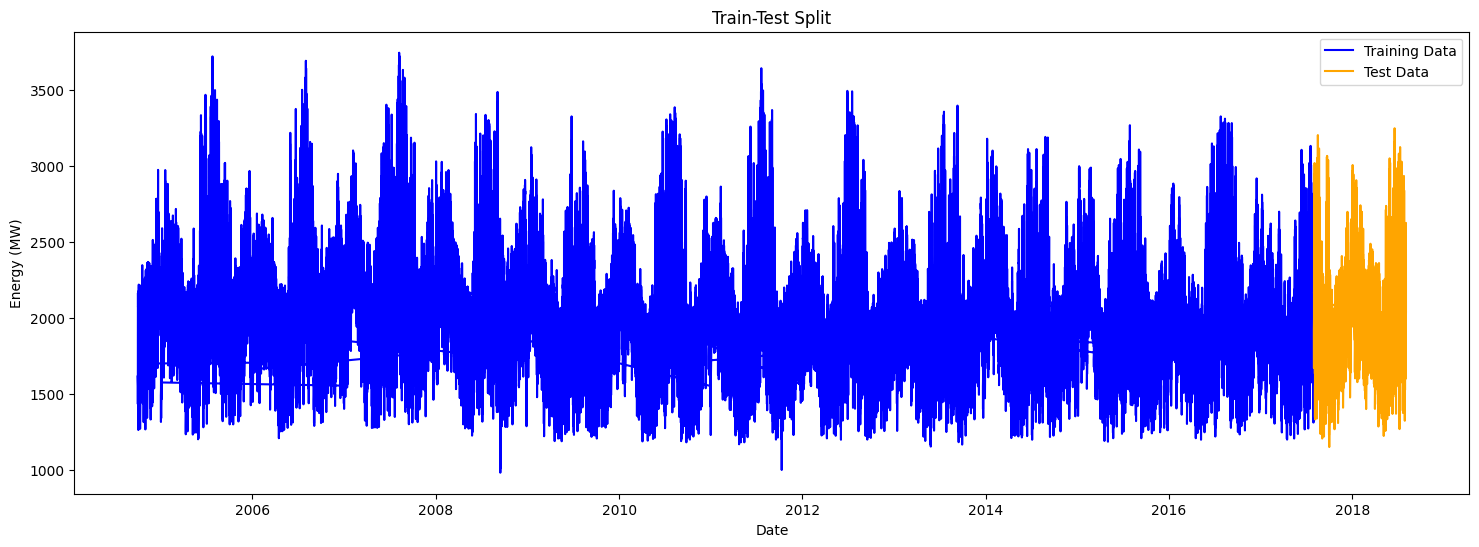

Training set size: 112298 samples
Test set size: 8809 samples


In [10]:
# --- 3. Train-Test Split ---
# We will use the last year of data as our test set.
split_date = '2017-08-01'
train = df_features.loc[df_features.index < split_date]
test = df_features.loc[df_features.index >= split_date]

# Separate features (X) and target (y)
X_train = train.drop('energy_mw', axis=1)
y_train = train['energy_mw']
X_test = test.drop('energy_mw', axis=1)
y_test = test['energy_mw']

# --- Visualize the split ---
plt.figure(figsize=(18, 6))
plt.plot(train.index, y_train, label='Training Data', color='blue')
plt.plot(test.index, y_test, label='Test Data', color='orange')
plt.title('Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Energy (MW)')
plt.legend()
plt.show()

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

In [11]:
# --- 4. Feature Scaling ---
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# For the LSTM model, we also need to scale the target variable
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

print("Data has been scaled successfully.")

Data has been scaled successfully.


In [12]:
# --- Helper function for model evaluation ---
def evaluate_model(y_true, y_pred, model_name):
    """
    Calculates and prints regression metrics.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}\n")

    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Store results
model_performance = []

In [13]:
# --- Train Linear Regression Model ---
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# --- Make Predictions ---
lr_predictions = lr_model.predict(X_test_scaled)

# --- Evaluate ---
lr_metrics = evaluate_model(y_test, lr_predictions, 'Linear Regression')
model_performance.append(lr_metrics)

--- Linear Regression Performance ---
RMSE: 66.8767
MAE: 44.8256
R-squared (R²): 0.9667



In [14]:
# --- Train Random Forest Model ---
# Using a subset of estimators for faster training as a demo
rf_model = RandomForestRegressor(n_estimators=100,
                                 random_state=42,
                                 max_depth=10,
                                 n_jobs=-1,
                                 min_samples_split=5)
rf_model.fit(X_train_scaled, y_train)

# --- Make Predictions ---
rf_predictions = rf_model.predict(X_test_scaled)

# --- Evaluate ---
rf_metrics = evaluate_model(y_test, rf_predictions, 'Random Forest')
model_performance.append(rf_metrics)

--- Random Forest Performance ---
RMSE: 45.7719
MAE: 30.3430
R-squared (R²): 0.9844



In [15]:
# --- Prepare data for LSTM ---
# LSTM requires input data in a 3D format: [samples, timesteps, features]
# We will use a sequence of past observations to predict the next one.
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24  # Use past 24 hours of data to predict the next hour

# Create sequences for training and testing
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")

X_train_seq shape: (112274, 24, 13)
y_train_seq shape: (112274, 1)
X_test_seq shape: (8785, 24, 13)
y_test_seq shape: (8785, 1)


In [18]:
# --- Build the LSTM Model ---
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

# --- Train the LSTM Model ---
# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 24, 50)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,051 (129.11 KB)

 Trainable params: 33,051 (129.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - loss: 0.0103 - val_loss: 0.0016
Epoch 2/50
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 78s 23ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 3/50
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 77s 24ms/step - loss: 0.0015 - val_loss: 8.5266e-04
Epoch 4/50
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 79s 23ms/step - loss: 0.0012 - val_loss: 7.4735e-04
Epoch 5/50
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 83s 24ms/step - loss: 0.0011 - val_loss: 7.7498e-04
Epoch 6/50
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - loss: 9.8378e-04 - val_loss: 8.0063e-04
Epoch 7/50
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 83s 24ms/step - loss: 9.3206e-04 - val_loss: 6.0658e-04
Epoch 8/50
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - loss: 8.7967e-04 - val_loss: 7.2775e-04
Epoch 9/50
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 83s 24ms/step - loss: 8.4027e-04 - val_loss: 7.4169e-04
Epoch 10/50
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - loss: 8.1085e-04 - val_loss: 6.5096e-04
Epoch 11/50
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 83s 

In [19]:
# --- Make Predictions with LSTM ---
lstm_predictions_scaled = lstm_model.predict(X_test_seq)

# --- Inverse transform predictions to original scale ---
lstm_predictions = y_scaler.inverse_transform(lstm_predictions_scaled).flatten()

# The true values for comparison need to be from y_test_seq, also inverse transformed
y_test_unscaled = y_scaler.inverse_transform(y_test_seq).flatten()


# --- Evaluate ---
lstm_metrics = evaluate_model(y_test_unscaled, lstm_predictions, 'LSTM')
model_performance.append(lstm_metrics)

275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
--- LSTM Performance ---
RMSE: 67.9937
MAE: 49.3241
R-squared (R²): 0.9656



In [20]:
# --- Performance Comparison Table ---
performance_df = pd.DataFrame(model_performance).set_index('Model')
print("Model Performance Comparison:")
print(performance_df)

Model Performance Comparison:
                        RMSE        MAE        R2
Model                                            
Linear Regression  66.876725  44.825618  0.966739
Random Forest      45.771863  30.343007  0.984419
LSTM               67.993710  49.324115  0.965641


/tmp/ipython-input-2914008264.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')


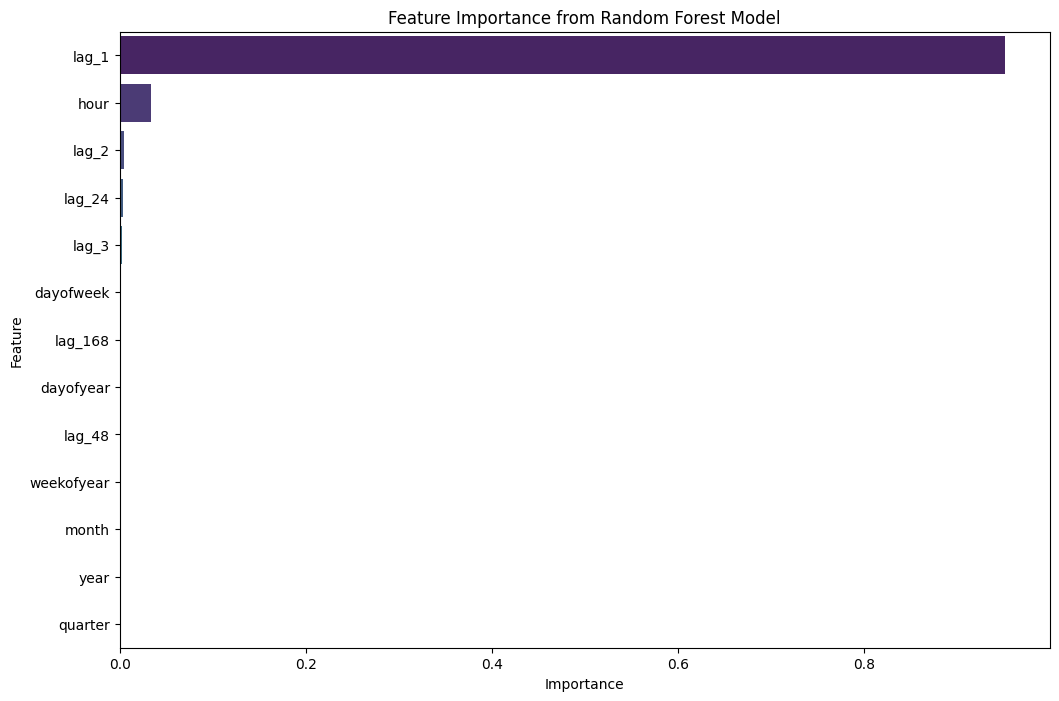


Top 5 Most Important Features:
   feature  importance
7    lag_1    0.952096
0     hour    0.033864
8    lag_2    0.004169
10  lag_24    0.003720
9    lag_3    0.002384


In [21]:
# --- Get Feature Importances ---
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# --- Plot Feature Importances ---
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importances.head(5))

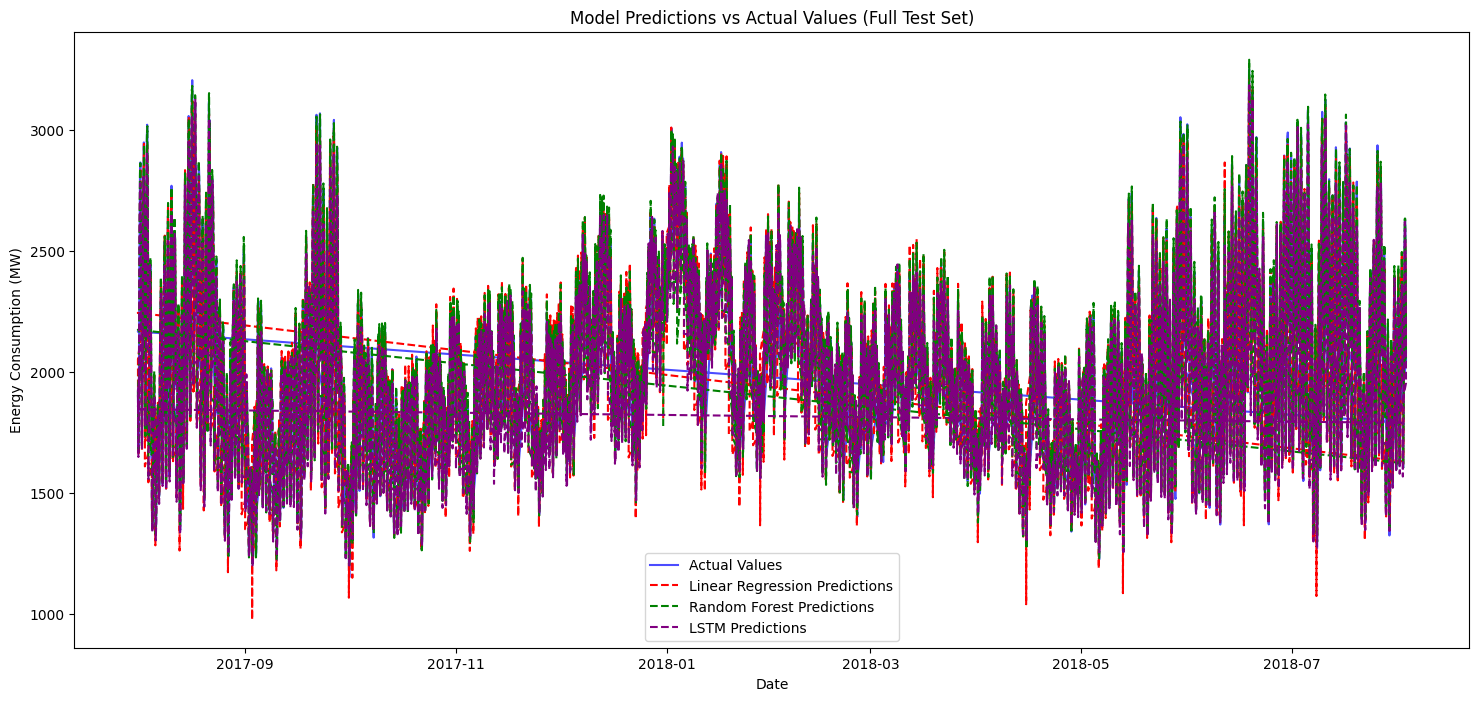

In [22]:
# --- Actual vs. Predicted Plot ---
# We need to align the LSTM predictions with the correct dates
test_dates = test.index[TIME_STEPS:]

plt.figure(figsize=(18, 8))
plt.plot(test_dates, y_test_unscaled, label='Actual Values', color='blue', alpha=0.7)
plt.plot(test.index, lr_predictions, label='Linear Regression Predictions', color='red', linestyle='--')
plt.plot(test.index, rf_predictions, label='Random Forest Predictions', color='green', linestyle='--')
plt.plot(test_dates, lstm_predictions, label='LSTM Predictions', color='purple', linestyle='--')

plt.title('Model Predictions vs Actual Values (Full Test Set)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

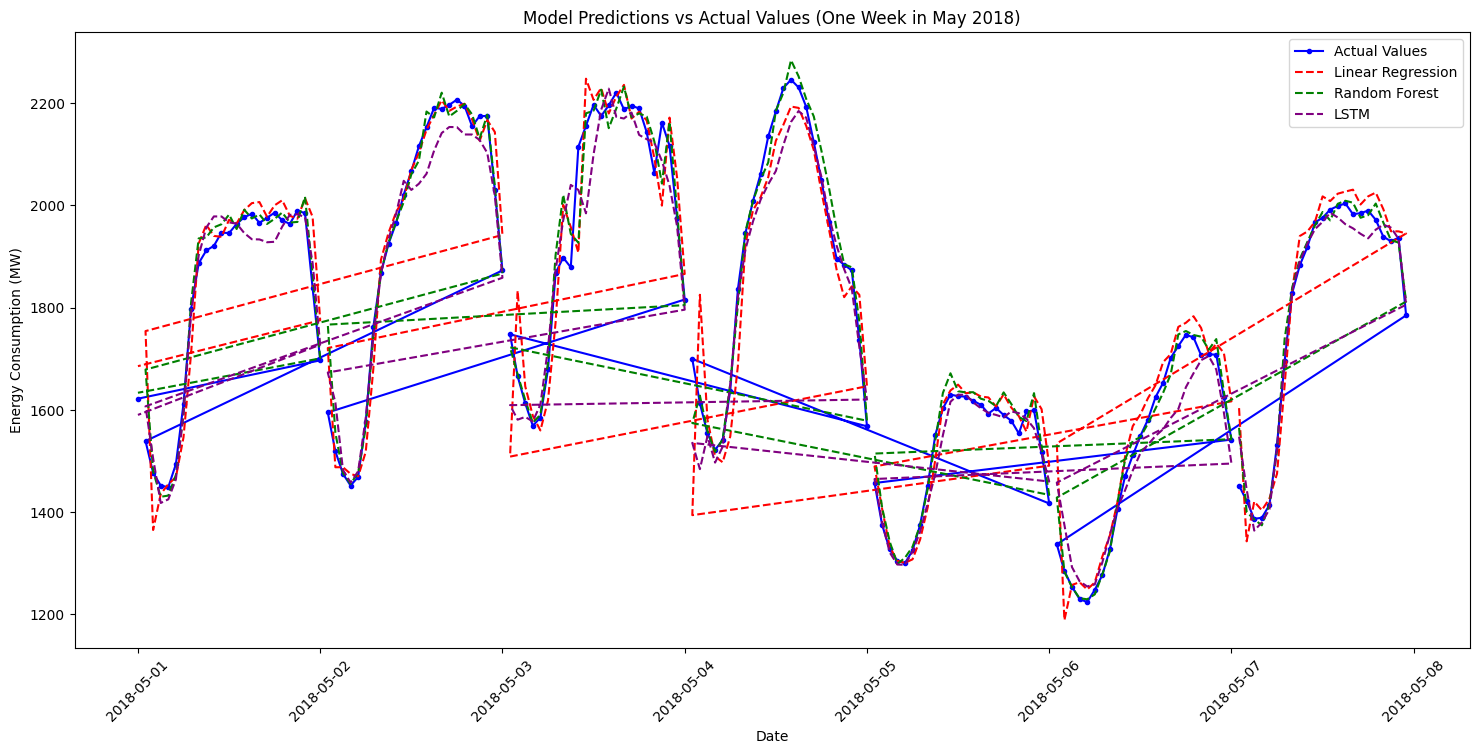

In [23]:
# --- Zoomed-in Actual vs. Predicted Plot (One Week) ---
start_date = '2018-05-01'
end_date = '2018-05-08'

# Filter the data for the specific date range
mask_full = (test.index >= start_date) & (test.index < end_date)
mask_lstm = (test_dates >= start_date) & (test_dates < end_date)


plt.figure(figsize=(18, 8))
plt.plot(test.index[mask_full], y_test[mask_full], label='Actual Values', color='blue', marker='.', linestyle='-')
plt.plot(test.index[mask_full], lr_predictions[mask_full], label='Linear Regression', color='red', linestyle='--')
plt.plot(test.index[mask_full], rf_predictions[mask_full], label='Random Forest', color='green', linestyle='--')
plt.plot(test_dates[mask_lstm], lstm_predictions[np.where(mask_lstm)[0]], label='LSTM', color='purple', linestyle='--')

plt.title('Model Predictions vs Actual Values (One Week in May 2018)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

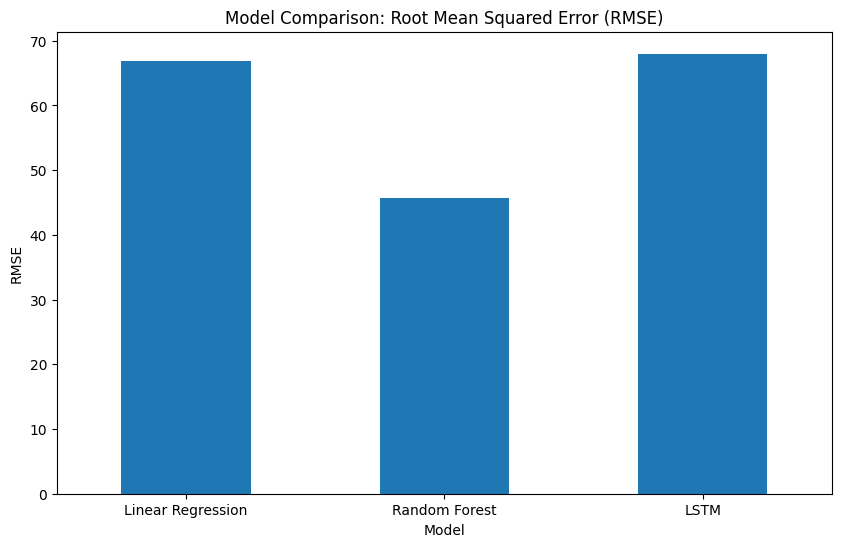

In [24]:
# --- Performance Comparison Chart ---
performance_df.plot(kind='bar', y='RMSE', figsize=(10, 6), legend=False)
plt.title('Model Comparison: Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xticks(rotation=0)
plt.show()